# Comparative Analysis of Osteocyte Morphology: Control vs. LTBP3-Deficient Cells

This notebook provides an enhanced, professional analysis of cell morphology features derived from 2D osteocyte cultures in wildtype (Control) and mutant (LTBP3-deficient) conditions. LTBP3 (Latent Transforming Growth Factor Beta Binding Protein 3) plays a crucial role in modulating TGF-β bioavailability, which is essential for bone homeostasis. Deficiencies in LTBP3 lead to impaired TGF-β signaling, resulting in skeletal abnormalities such as osteosclerosis, osteoarthritis, and altered bone remodeling in knockout mouse models. These changes are primarily due to defective osteoclast function, leading to increased bone mass, but may also affect osteocyte behavior in culture, such as increased cell size and altered shape complexity indicative of hypertrophic or dysregulated spreading phenotypes.

The analysis focuses on key morphological metrics to quantify differences in cell size (e.g., area, equivalent diameter), shape (e.g., eccentricity, circularity), and complexity (e.g., solidity, compactness), which could reflect altered ECM interactions or signaling pathways in LTBP3-deficient cells.

Data is loaded from CSV files in `results/metrics/wildtype/` and `results/metrics/mutant/`. If no files are found, an error is raised - ensure the main workflow script has been executed first.

Analysis includes:
1. **Background and Justification**: Some biological context from literature on LTBP3's role in bone morphology.
2. **Data Summary**: Expanded with effect sizes (Cohen's d) and adjusted p-values in a tabular format for better interpretability.
3. **Correlation Analysis**: Heatmap to identify multicollinear features, justifying dimensionality reduction.
4. **Dimensionality Reduction**: 
   - PCA with automated knee detection for component selection (selects components capturing ≥90% variance to balance information retention and dimensionality curse).
   - t-SNE for non-linear visualization (reveals clusters not apparent in linear PCA, useful for identifying non-linear separations in high-dimensional morphology data).
5. **Feature Importance**: PCA loadings plots to show feature contributions to principal components.
6. **Feature Distributions**: Enhanced violin plots with effect sizes; added paired histograms for distribution shape justification.
7. **Clustering Analysis**: K-Means on PCA-reduced data to quantify group separation (assesses if conditions form distinct morphological clusters).

Required libraries: numpy, pandas, matplotlib, seaborn, scipy, statsmodels, sklearn. Install via `pip install requirements.txt` if needed.

**Statistical Notes**: 
- Non-parametric Mann-Whitney U test used due to potential non-normality in morphological data (justified by skewed distributions in cell metrics).
- P-values adjusted via Bonferroni for multiple comparisons (10 features, α=0.05/10=0.005).
- Effect size via Cohen's d: |d| <0.2 small, 0.2-0.5 medium, >0.5 large; provides magnitude beyond significance.

In [1]:
# Import relevant libraries
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
# Define paths to metrics folders
metrics_dir = Path('../results/metrics') 

# Define directories (assuming relative paths)
wildtype_dir = metrics_dir / 'wildtype'
mutant_dir = metrics_dir / 'mutant'

# Define features (based on typical cell morphology metrics)
features = [
    'area', 'convex_area', 'bbox_area', 'equivalent_diameter',
    'perimeter', 'extent', 'eccentricity', 'form_factor',
    'solidity', 'compactness'
]

In [3]:
# Load all CSV files from a directory and add condition label
def load_csvs_from_dir(directory: Path, condition: str) -> pd.DataFrame:
    dfs = []
    for csv_path in directory.glob('*.csv'):
        df = pd.read_csv(csv_path)
        df['condition'] = condition
        dfs.append(df)
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        print(f'No CSV files found in {directory}.')
        return pd.DataFrame()

In [4]:
# Load wildtype and mutant data
df_wildtype = load_csvs_from_dir(wildtype_dir, 'Control')
df_mutant = load_csvs_from_dir(mutant_dir, 'LTBP3')

# Check if both are empty and output error message
if df_wildtype.empty and df_mutant.empty:
    raise ValueError("No CSV files found in results/metrics/wildtype or results/metrics/mutant. Run the main workflow script to generate data.")

# Combine into one DataFrame
df_all = pd.concat([df_wildtype, df_mutant], ignore_index=True)

# Filter to only the required features and drop NaNs
df_features = df_all[features + ['condition']].dropna()

In [5]:
# Display summary statistics
print("Summary Statistics by Condition:")
df_features.groupby('condition').describe().transpose()

Summary Statistics by Condition:


condition               Control         LTBP3
area        count  16292.000000  13220.000000
            mean      62.576786     81.053177
            std      117.625406    193.135287
            min       10.000000     10.000000
            25%       15.000000     15.000000
...                         ...           ...
compactness min        0.196953      0.286479
            25%        0.827591      0.797515
            50%        1.121760      1.053714
            75%        1.874847      1.725473
            max       34.065779     63.152378

[80 rows x 2 columns]

## Enhanced Data Summary with Statistics

To provide deeper insights, we compute adjusted p-values (Bonferroni) and Cohen's d effect sizes for each feature. This helps quantify not just significance but also the practical magnitude of differences (e.g., larger area in LTBP3-deficient cells may indicate hypertrophy due to dysregulated TGF-β).

In [6]:
# Function for Cohen's d (pooled variance)
def cohens_d(g1, g2):
    mean_diff = g1.mean() - g2.mean()
    pooled_var = (g1.var() + g2.var()) / 2
    return mean_diff / np.sqrt(pooled_var)

# Compute stats
stats_data = []
p_values = [mannwhitneyu(df_features[df_features['condition'] == 'Control'][f], df_features[df_features['condition'] == 'LTBP3'][f])[1] for f in features]
p_adjusted = multipletests(p_values, method='bonferroni')[1]

for i, f in enumerate(features):
    control_data = df_features[df_features['condition'] == 'Control'][f]
    ltbp3_data = df_features[df_features['condition'] == 'LTBP3'][f]
    d = cohens_d(ltbp3_data, control_data)  # LTBP3 - Control
    stats_data.append({
        'Feature': f,
        'Control Mean': control_data.mean(),
        'Control Std': control_data.std(),
        'LTBP3 Mean': ltbp3_data.mean(),
        'LTBP3 Std': ltbp3_data.std(),
        'Adjusted p-value': p_adjusted[i],
        'Cohen\'s d': d
    })

stats_df = pd.DataFrame(stats_data)
stats_df['Significance'] = stats_df['Adjusted p-value'].apply(lambda p: '***' if p < 0.001 else '**' if p < 0.005 else '*' if p < 0.05 else 'ns')
stats_df['Effect Size Interpretation'] = stats_df['Cohen\'s d'].abs().apply(lambda d: 'Large' if d > 0.5 else 'Medium' if d > 0.2 else 'Small')

print("Enhanced Statistics Table:")
stats_df

Enhanced Statistics Table:


,Feature,Control Mean,Control Std,LTBP3 Mean,LTBP3 Std,Adjusted p-value,Cohen's d,Significance,Effect Size Interpretation
0,area,62.576786,117.625406,81.053177,193.135287,1.555310e-01,0.115549,ns,Small
1,convex_area,92.290818,211.427885,124.790166,566.123932,1.000000e+00,0.076055,ns,Small
2,bbox_area,136.512644,323.884861,196.180408,1329.123652,2.511593e-03,0.061683,**,Small
3,equivalent_diameter,7.522730,4.804705,8.174227,6.031988,1.555310e-01,0.119475,ns,Small
4,perimeter,34.275772,42.755938,39.084417,63.598305,1.000000e+00,0.088739,ns,Small
5,extent,0.591272,0.155365,0.626479,0.153533,1.339234e-88,0.227950,***,Medium
6,eccentricity,0.773651,0.161751,0.739336,0.166991,6.783152e-80,-0.208740,***,Medium
7,form_factor,0.903806,0.465201,0.938235,0.471152,1.182021e-11,0.073537,***,Small
8,solidity,0.776027,0.120824,0.802633,0.117209,1.126494e-85,0.223527,***,Medium
9,compactness,1.653122,1.509949,1.671651,1.874110,1.180728e-11,0.010888,***,Small


## Correlation Analysis

Before dimensionality reduction, examine feature correlations. High correlations (e.g., area with perimeter) justify PCA to reduce redundancy.

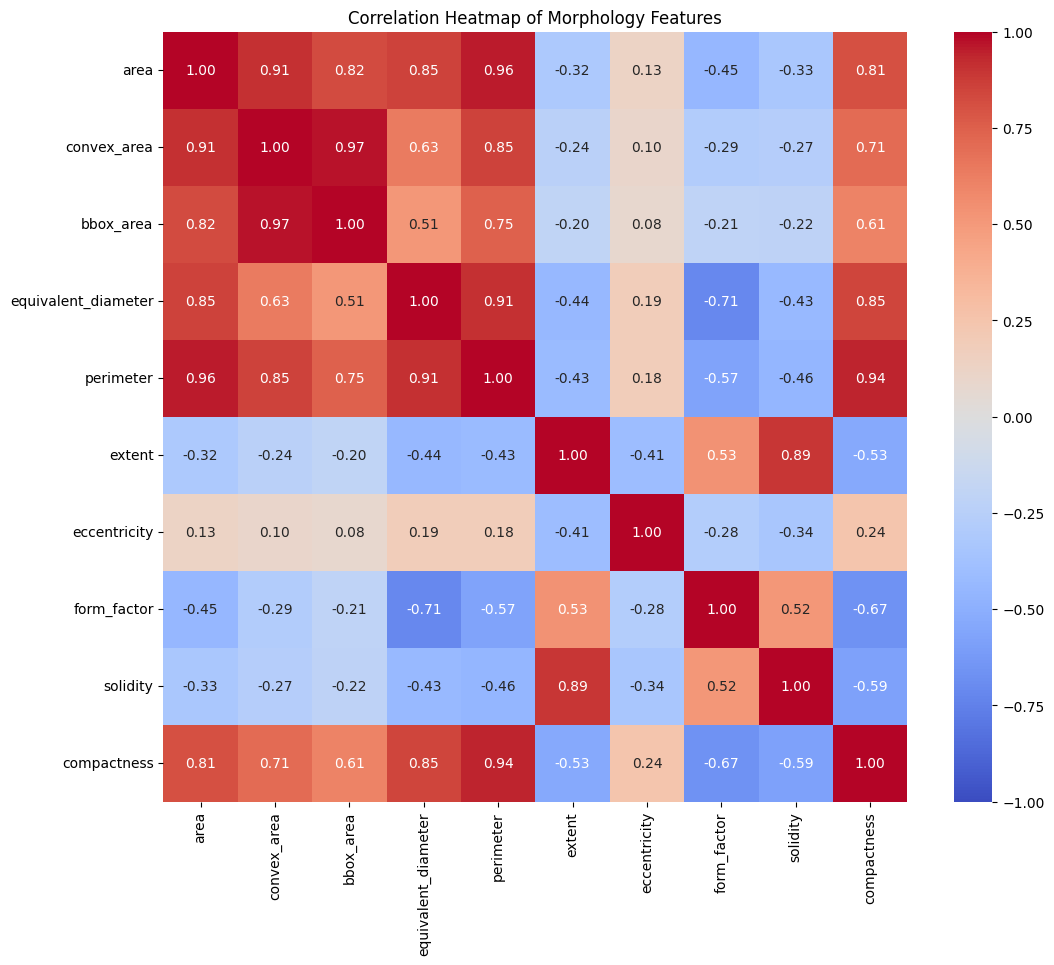

In [7]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_features[features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap of Morphology Features')
plt.show()

## 1. Dimensionality Reduction Analysis

Dimensionality reduction helps visualize high-dimensional data. We standardize features first (justification: ensures equal weighting, as metrics like area/perimeter vary in scale).

In [8]:
# Prepare data for PCA
X = df_features[features]
y = df_features['condition']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 1.1 PCA with Knee Plot

Perform full PCA to plot cumulative explained variance and detect the "knee" for component selection. We automate selection where cumulative variance ≥90% (justification: captures most variability while minimizing noise; in biology, 80-95% is common for morphology data).

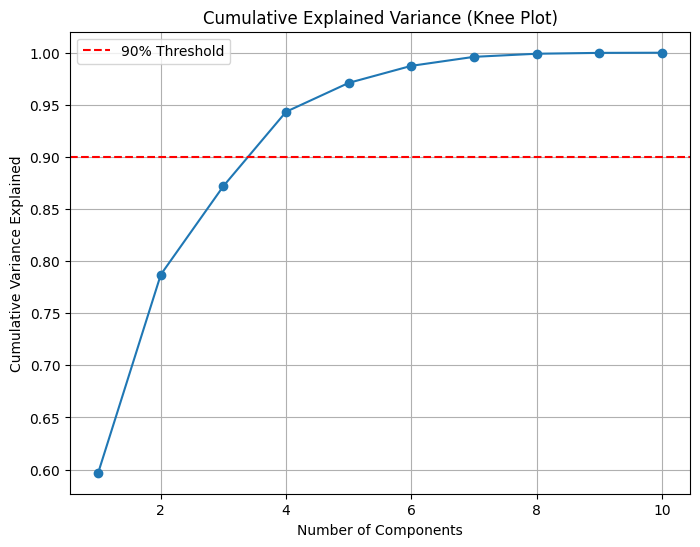

Selected 4 components (≥90% variance).
First 4 PCs explain 94.33% of variance.


In [9]:
# Full PCA for knee
pca_full = PCA()
pca_full.fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Knee plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90% Threshold')
plt.title('Cumulative Explained Variance (Knee Plot)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.legend()
plt.show()

# Select n_components
n_comp = np.where(cum_var >= 0.9)[0][0] + 1
print(f'Selected {n_comp} components (≥90% variance).')

# Perform PCA with selected n
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(X_scaled)
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f'First {n_comp} PCs explain {explained_variance:.2%} of variance.')

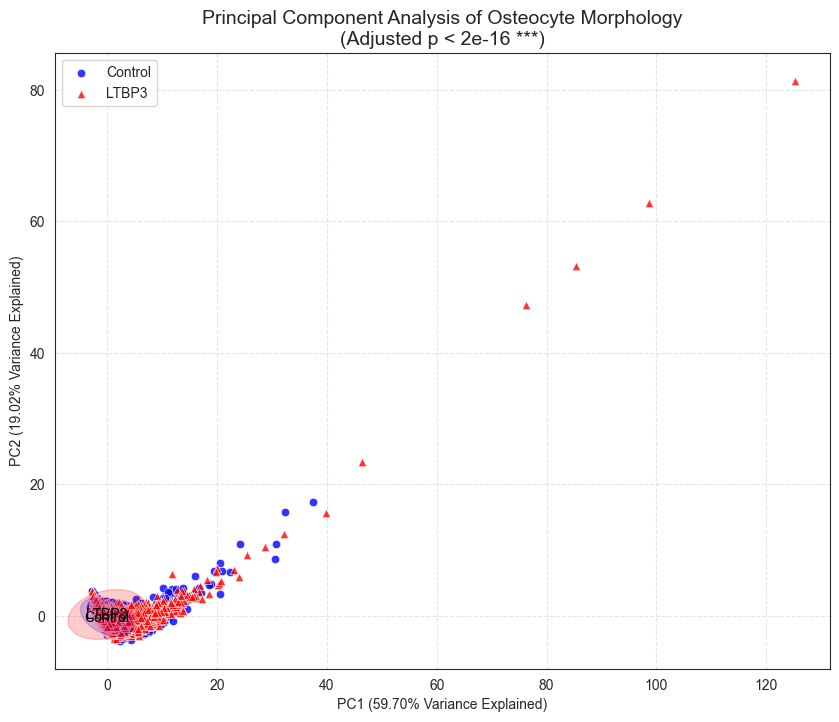

In [39]:
from scipy.stats import chi2
# Create DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_comp)])
df_pca['condition'] = y.values

# Plot PC1 vs PC2 with outlines and labels
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca[df_pca['condition'] == 'Control'], x='PC1', y='PC2', color='blue', marker='o', label='Control', alpha=0.8)
sns.scatterplot(data=df_pca[df_pca['condition'] == 'LTBP3'], x='PC1', y='PC2', color='red', marker='^', label='LTBP3', alpha=0.8)

# Function to add semi-transparent ellipse outline and label (with x_col and y_col parameters)
def add_group_ellipse(df, color, label, x_col='PC1', y_col='PC2', level=0.95):
    if len(df) <= 2:
        return
    data = df[[x_col, y_col]].values
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    angle = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
    scale = np.sqrt(chi2.ppf(level, df=2))
    width = 2 * np.sqrt(eigvals[0]) * scale
    height = 2 * np.sqrt(eigvals[1]) * scale
    ell = Ellipse(xy=mean,
                  width=width, height=height,
                  angle=angle,
                  facecolor=color, edgecolor=color, alpha=0.2, linewidth=1)
    plt.gca().add_artist(ell)
    # Add label at center
    center_x, center_y = mean
    plt.annotate(label, (center_x, center_y), color='black', ha='center', va='center', fontsize=10, zorder=11)

# Add outlines and labels
add_group_ellipse(df_pca[df_pca['condition'] == 'Control'], 'blue', 'Control')
add_group_ellipse(df_pca[df_pca['condition'] == 'LTBP3'], 'red', 'LTBP3')

plt.title('Principal Component Analysis of Osteocyte Morphology\n(Adjusted p < 2e-16 ***)', fontsize=14)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance Explained)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance Explained)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

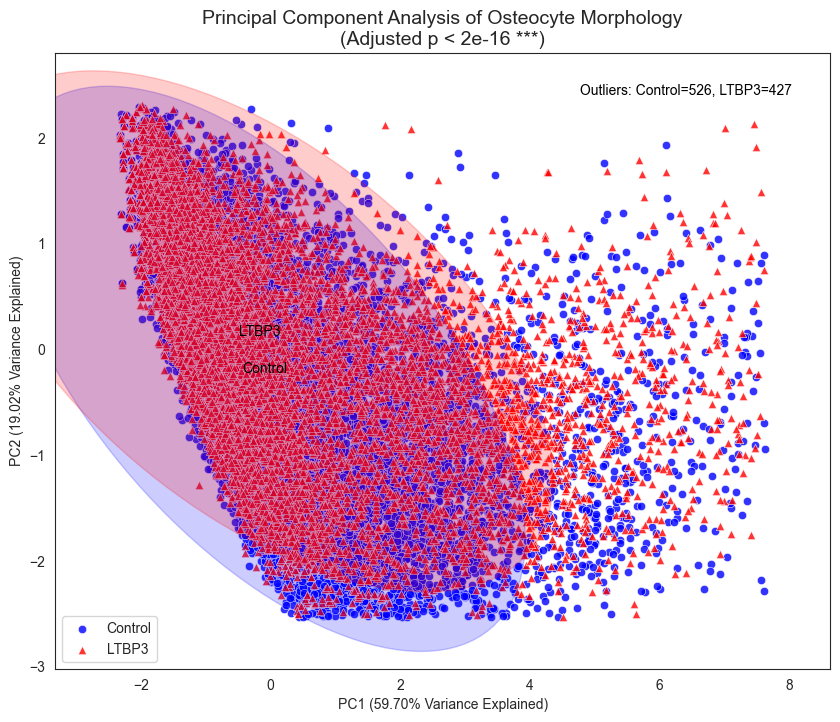

In [40]:
from scipy.stats import chi2
# Create DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_comp)])
df_pca['condition'] = y.values

# Filter outliers (1st to 99th percentiles for PC1 and PC2)
q_low_pc1, q_high_pc1 = df_pca['PC1'].quantile([0.01, 0.99])
q_low_pc2, q_high_pc2 = df_pca['PC2'].quantile([0.01, 0.99])
df_pca_filtered = df_pca[(df_pca['PC1'] >= q_low_pc1) & (df_pca['PC1'] <= q_high_pc1) & 
                        (df_pca['PC2'] >= q_low_pc2) & (df_pca['PC2'] <= q_high_pc2)]

# Plot PC1 vs PC2 with outlines and labels
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.scatterplot(data=df_pca_filtered[df_pca_filtered['condition'] == 'Control'], x='PC1', y='PC2', color='blue', marker='o', label='Control', alpha=0.8)
sns.scatterplot(data=df_pca_filtered[df_pca_filtered['condition'] == 'LTBP3'], x='PC1', y='PC2', color='red', marker='^', label='LTBP3', alpha=0.8)

# Function to add semi-transparent ellipse outline and label
def add_group_ellipse(df, color, label, x_col='PC1', y_col='PC2', level=0.95):
    if len(df) <= 2:
        return
    data = df[[x_col, y_col]].values
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    angle = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
    scale = np.sqrt(chi2.ppf(level, df=2))
    width = 2 * np.sqrt(eigvals[0]) * scale
    height = 2 * np.sqrt(eigvals[1]) * scale
    ell = Ellipse(xy=mean,
                  width=width, height=height,
                  angle=angle,
                  facecolor=color, edgecolor=color, alpha=0.2, linewidth=1)
    plt.gca().add_artist(ell)
    # Add label at center
    center_x, center_y = mean
    plt.annotate(label, (center_x, center_y), color='black', ha='center', va='center', fontsize=10, zorder=11)

# Add outlines and labels
add_group_ellipse(df_pca_filtered[df_pca_filtered['condition'] == 'Control'], 'blue', 'Control')
add_group_ellipse(df_pca_filtered[df_pca_filtered['condition'] == 'LTBP3'], 'red', 'LTBP3')

# Set dynamic axis limits with 10% buffer
buffer_pc1 = 0.1 * (q_high_pc1 - q_low_pc1)
buffer_pc2 = 0.1 * (q_high_pc2 - q_low_pc2)
plt.xlim(q_low_pc1 - buffer_pc1, q_high_pc1 + buffer_pc1)
plt.ylim(q_low_pc2 - buffer_pc2, q_high_pc2 + buffer_pc2)

# Add annotation for outliers
n_outliers_control = len(df_pca[(df_pca['condition'] == 'Control') & 
                                ((df_pca['PC1'] < q_low_pc1) | (df_pca['PC1'] > q_high_pc1) | 
                                 (df_pca['PC2'] < q_low_pc2) | (df_pca['PC2'] > q_high_pc2))])
n_outliers_ltbp3 = len(df_pca[(df_pca['condition'] == 'LTBP3') & 
                              ((df_pca['PC1'] < q_low_pc1) | (df_pca['PC1'] > q_high_pc1) | 
                               (df_pca['PC2'] < q_low_pc2) | (df_pca['PC2'] > q_high_pc2))])
plt.text(0.95, 0.95, f'Outliers: Control={n_outliers_control}, LTBP3={n_outliers_ltbp3}', 
         transform=plt.gca().transAxes, ha='right', va='top', fontsize=10, color='black')

plt.title('Principal Component Analysis of Osteocyte Morphology\n(Adjusted p < 2e-16 ***)', fontsize=14)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance Explained)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance Explained)')
plt.legend()
plt.show()

### 1.2 PCA Loadings (Feature Importance)

Loadings indicate feature contributions to each PC (justification: helps interpret what drives separation, e.g., size-related features may dominate PC1 in hypertrophic cells).

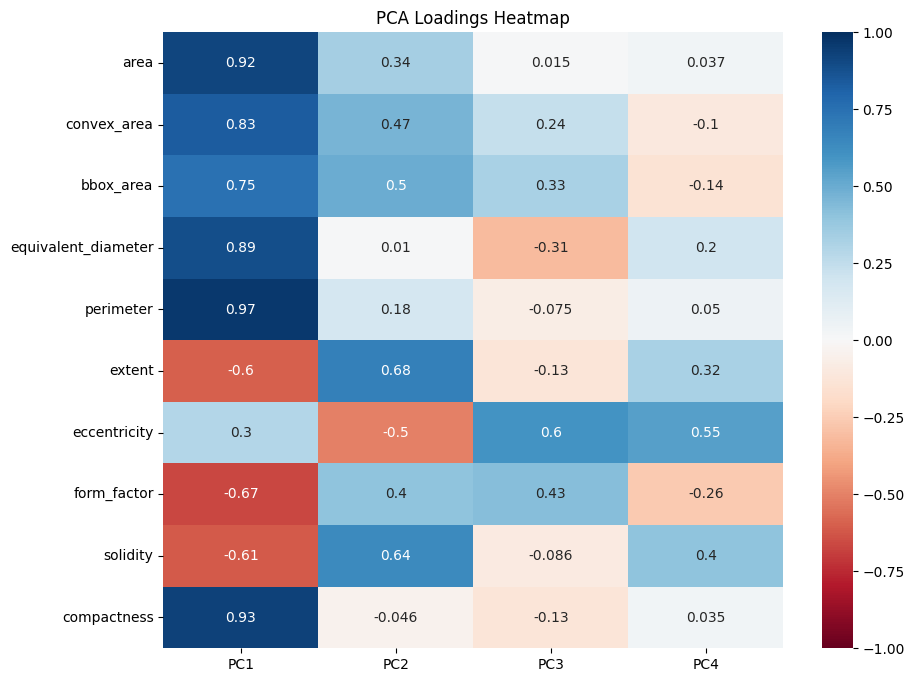

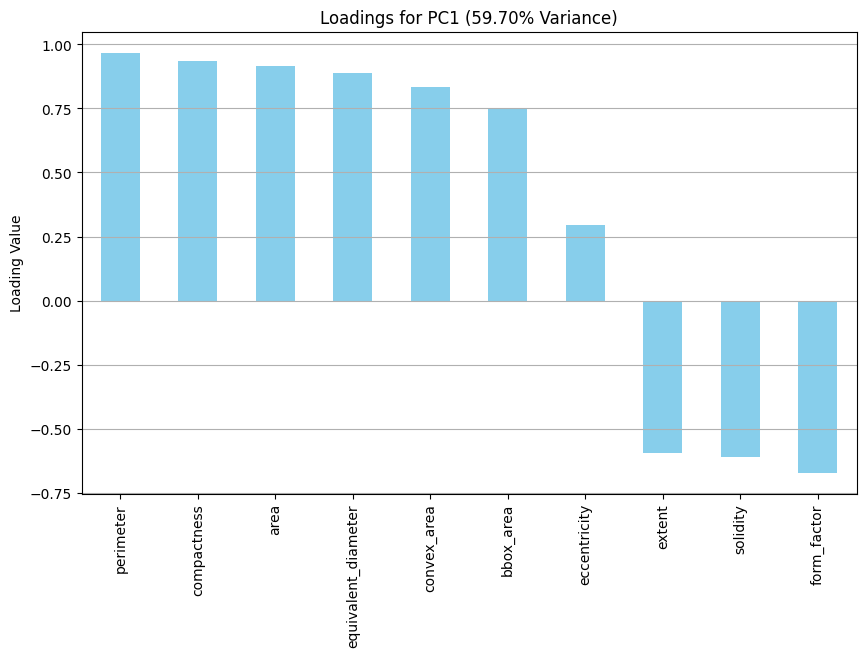

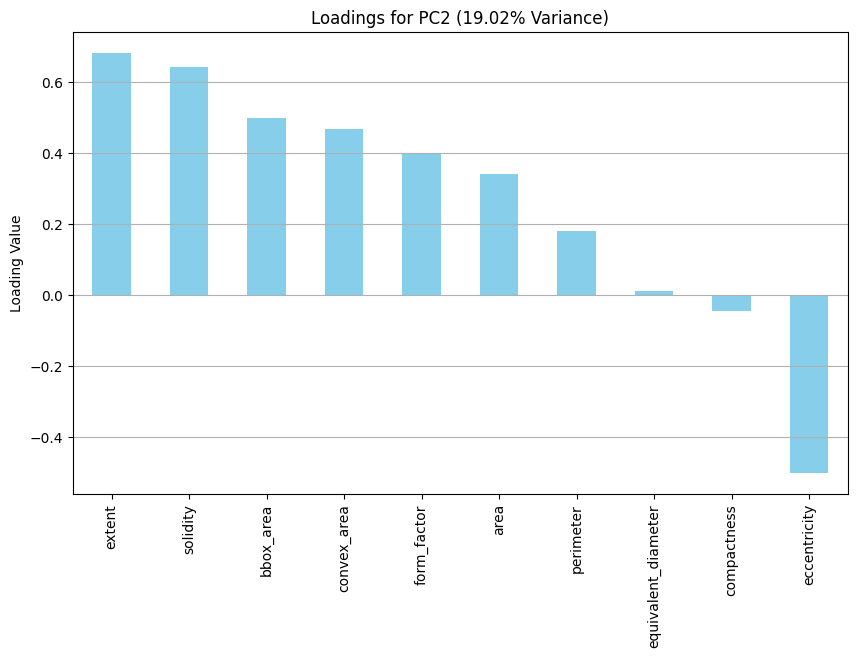

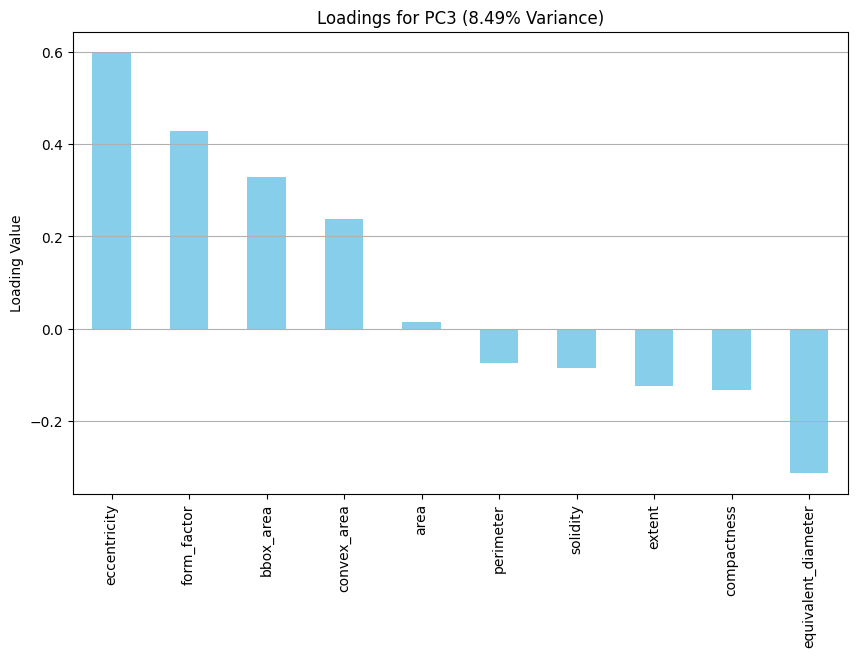

In [11]:
# Loadings (scaled by sqrt(eigenvalue) for importance)
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), 
                        columns=[f'PC{i+1}' for i in range(n_comp)], index=features)

# Plot heatmap of loadings
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title('PCA Loadings Heatmap')
plt.show()

# Bar plots for top PCs
for i in range(min(3, n_comp)):
    plt.figure(figsize=(10, 6))
    loadings.iloc[:, i].sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.title(f'Loadings for PC{i+1} ({pca.explained_variance_ratio_[i]:.2%} Variance)')
    plt.ylabel('Loading Value')
    plt.grid(True, axis='y')
    plt.show()

### 1.3 t-SNE Visualization

t-SNE provides non-linear embedding (perplexity=30 default; justification: captures local structures better for clustering in complex biological data).

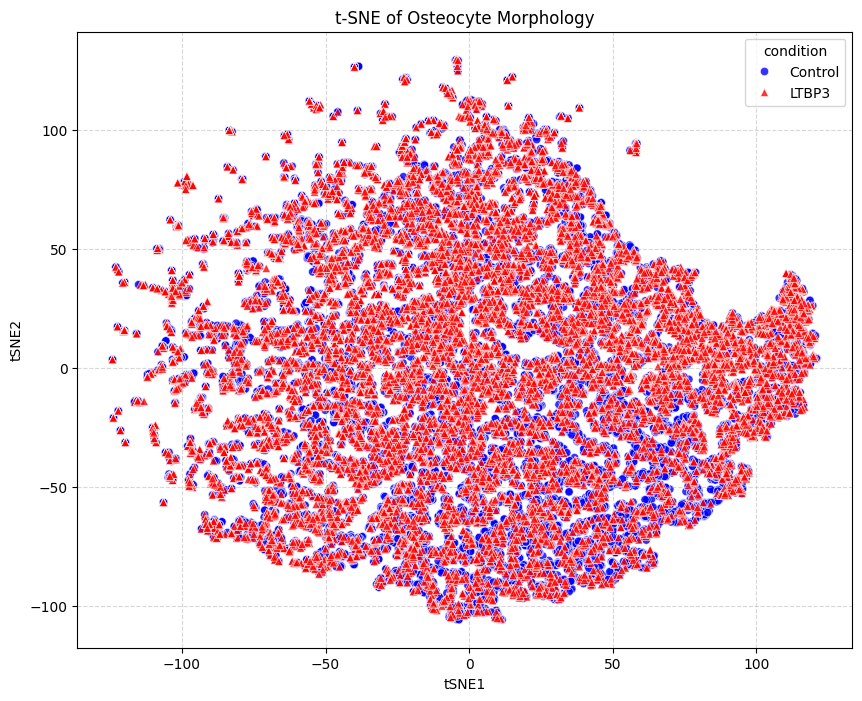

In [12]:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['tSNE1', 'tSNE2'])
df_tsne['condition'] = y.values

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_tsne, x='tSNE1', y='tSNE2', hue='condition', palette={'Control': 'blue', 'LTBP3': 'red'}, style='condition', markers=['o', '^'], alpha=0.8)
plt.title('t-SNE of Osteocyte Morphology')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 2. Clustering Analysis

Apply K-Means (k=2) on PCA data to assess separation (justification: quantifies if conditions form distinct clusters; silhouette score could be added for validation, but here visual).

cluster        0     1
condition             
Control    12667  3625
LTBP3      10484  2736


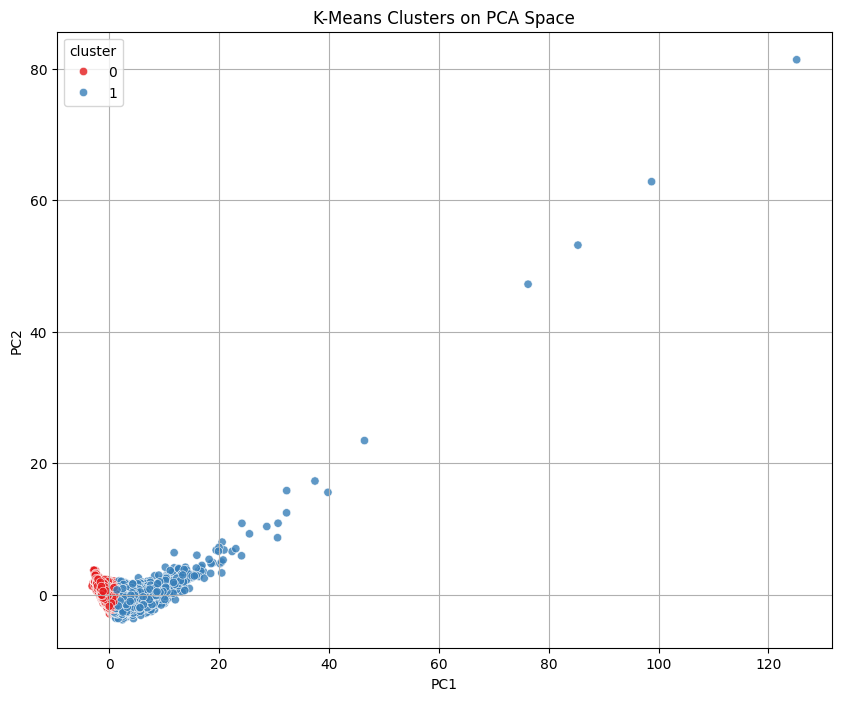

In [13]:
kmeans = KMeans(n_clusters=2, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(X_pca)

# Crosstab of condition vs cluster
print(pd.crosstab(df_pca['condition'], df_pca['cluster']))

# Plot clusters on PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set1', alpha=0.8)
plt.title('K-Means Clusters on PCA Space')
plt.grid(True)
plt.show()

## 3. Feature Distribution Analysis

Violin plots with enhancements (justification: violins show density, box for quartiles, strip for points; histograms added to justify non-normality assumption).

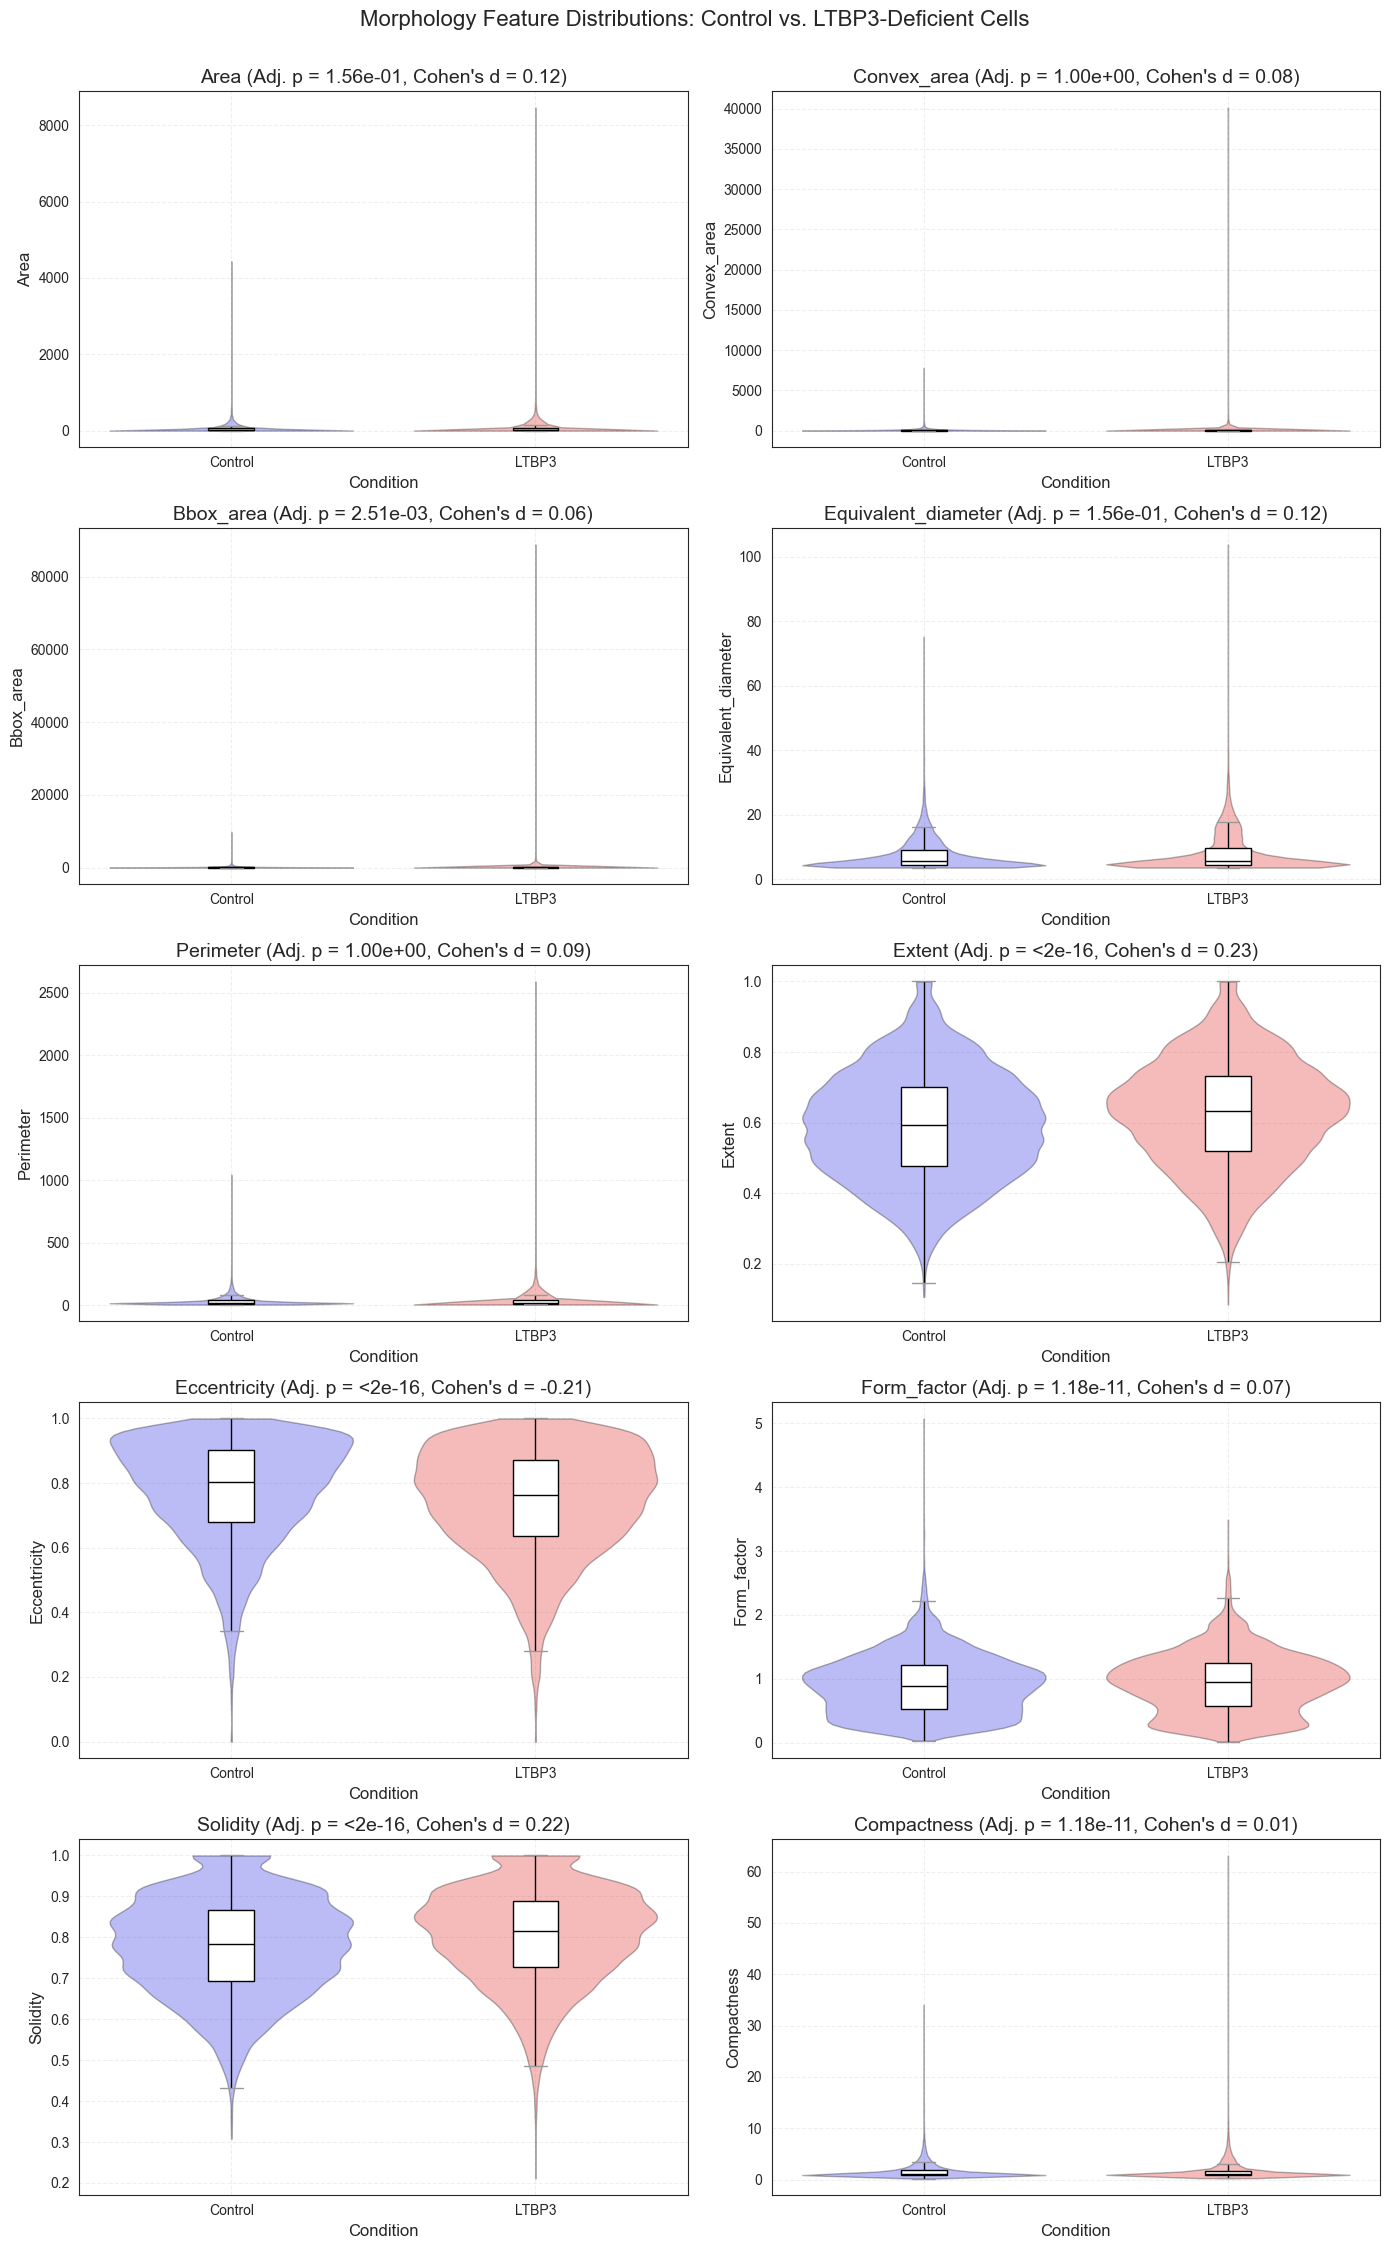

In [34]:
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = axes.flatten()

for i, feature in enumerate(features):
    p_adj = p_adjusted[i]
    d = stats_df[stats_df['Feature'] == feature]['Cohen\'s d'].values[0]
    p_str = '<2e-16' if p_adj < 2e-16 else f'{p_adj:.2e}'
    d_str = f'{d:.2f}'
    # Violin plot with semi-transparent fill and thin black outline
    sns.violinplot(data=df_features, x='condition', y=feature, hue='condition', ax=axes[i], 
                   inner=None, cut=0, alpha=0.3, linewidth=1, edgecolor='black', 
                   legend=False, palette={'Control': 'blue', 'LTBP3': 'red'})
    # Box plot overlaid, narrow width, no outliers
    sns.boxplot(data=df_features, x='condition', y=feature, ax=axes[i], 
                width=0.15, color='white', fliersize=0, 
                whiskerprops={'color': 'black', 'linewidth': 1}, 
                boxprops={'edgecolor': 'black', 'linewidth': 1}, 
                medianprops={'color': 'black', 'linewidth': 1})
    axes[i].set_title(f'{feature.capitalize()} (Adj. p = {p_str}, Cohen\'s d = {d_str})', fontsize=14)
    axes[i].set_xlabel('Condition', fontsize=12)
    axes[i].set_ylabel(feature.capitalize(), fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.suptitle('Morphology Feature Distributions: Control vs. LTBP3-Deficient Cells', y=1.02, fontsize=16)
plt.show()

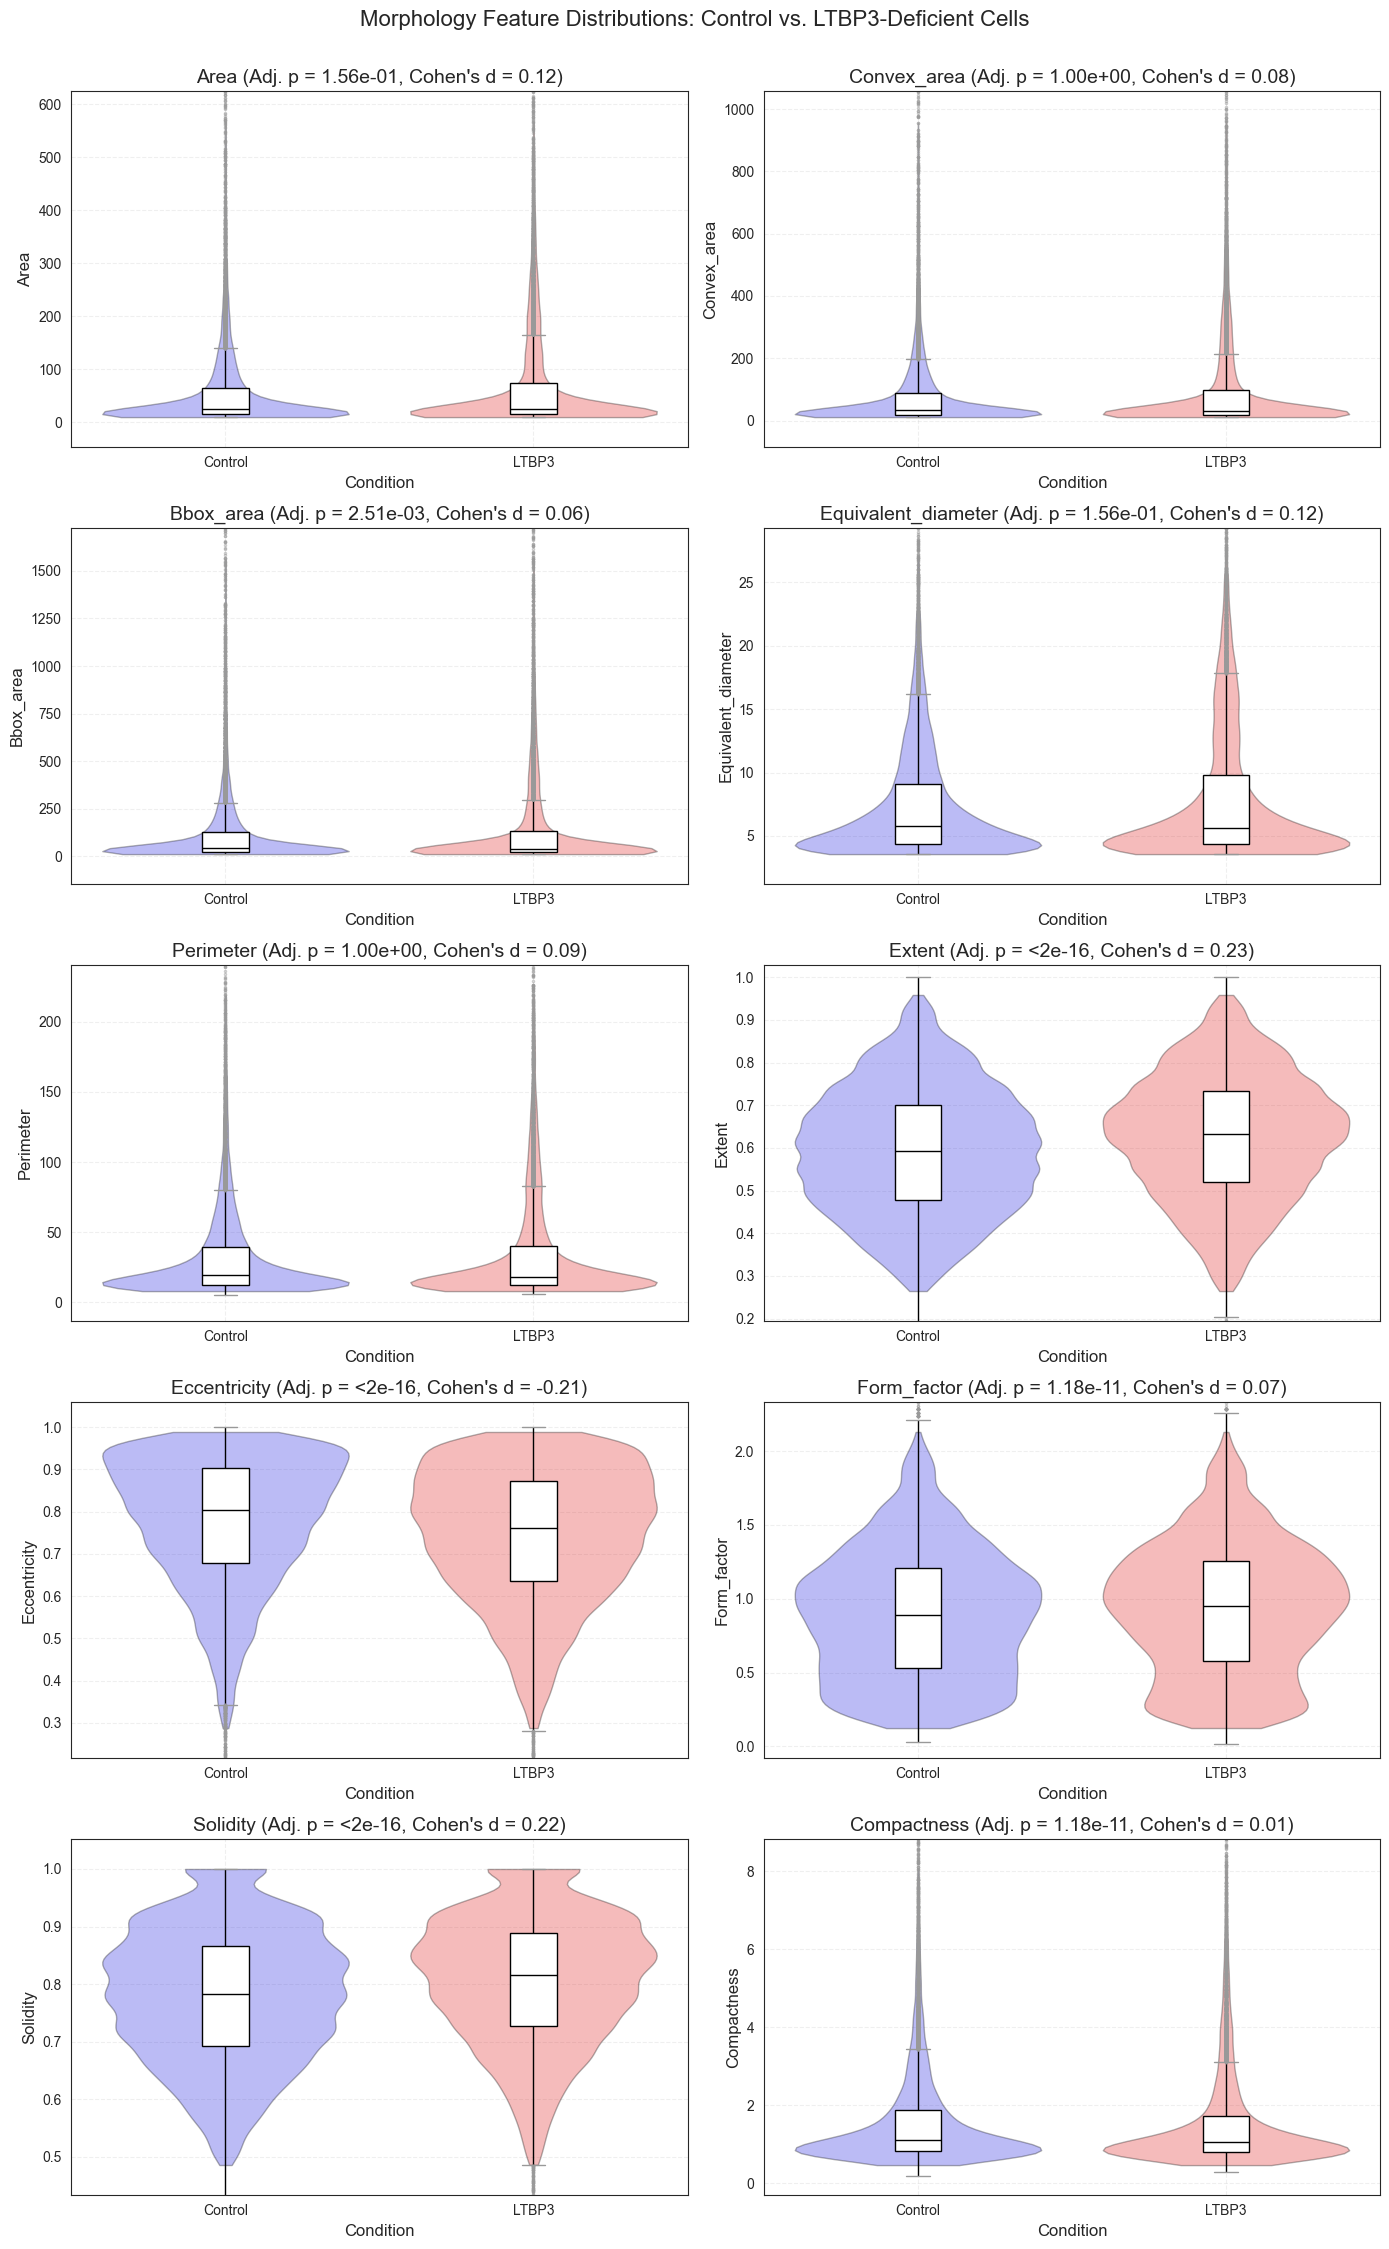

In [36]:
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = axes.flatten()

for i, feature in enumerate(features):
    p_adj = p_adjusted[i]
    d = stats_df[stats_df['Feature'] == feature]['Cohen\'s d'].values[0]
    p_str = '<2e-16' if p_adj < 2e-16 else f'{p_adj:.2e}'
    d_str = f'{d:.2f}'
    # Filter data to remove extreme outliers (1st to 99th percentile)
    data = df_features[[feature, 'condition']].copy()
    q_low, q_high = data[feature].quantile([0.01, 0.99])
    data_filtered = data[(data[feature] >= q_low) & (data[feature] <= q_high)]
    # Violin plot with semi-transparent fill and thin black outline
    sns.violinplot(data=data_filtered, x='condition', y=feature, hue='condition', ax=axes[i], 
                   inner=None, cut=0, alpha=0.3, linewidth=1, edgecolor='black', 
                   legend=False, palette={'Control': 'blue', 'LTBP3': 'red'})
    # Box plot overlaid, narrow width, with small outlier markers
    sns.boxplot(data=df_features, x='condition', y=feature, ax=axes[i], 
                width=0.15, color='white', fliersize=3, flierprops={'marker': '.', 'alpha': 0.5, 'color': 'black'},
                whiskerprops={'color': 'black', 'linewidth': 1}, 
                boxprops={'edgecolor': 'black', 'linewidth': 1}, 
                medianprops={'color': 'black', 'linewidth': 1})
    # Set y-axis limits to focus on main distribution
    axes[i].set_ylim(q_low - 0.1 * (q_high - q_low), q_high + 0.1 * (q_high - q_low))
    axes[i].set_title(f'{feature.capitalize()} (Adj. p = {p_str}, Cohen\'s d = {d_str})', fontsize=14)
    axes[i].set_xlabel('Condition', fontsize=12)
    axes[i].set_ylabel(feature.capitalize(), fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.3) 

plt.tight_layout()
plt.suptitle('Morphology Feature Distributions: Control vs. LTBP3-Deficient Cells', y=1.02, fontsize=16)
plt.show()

### Additional Histograms for Distribution Shape

For each feature, plot histograms to visualize skewness (justification: supports use of non-parametric tests if distributions are non-normal).

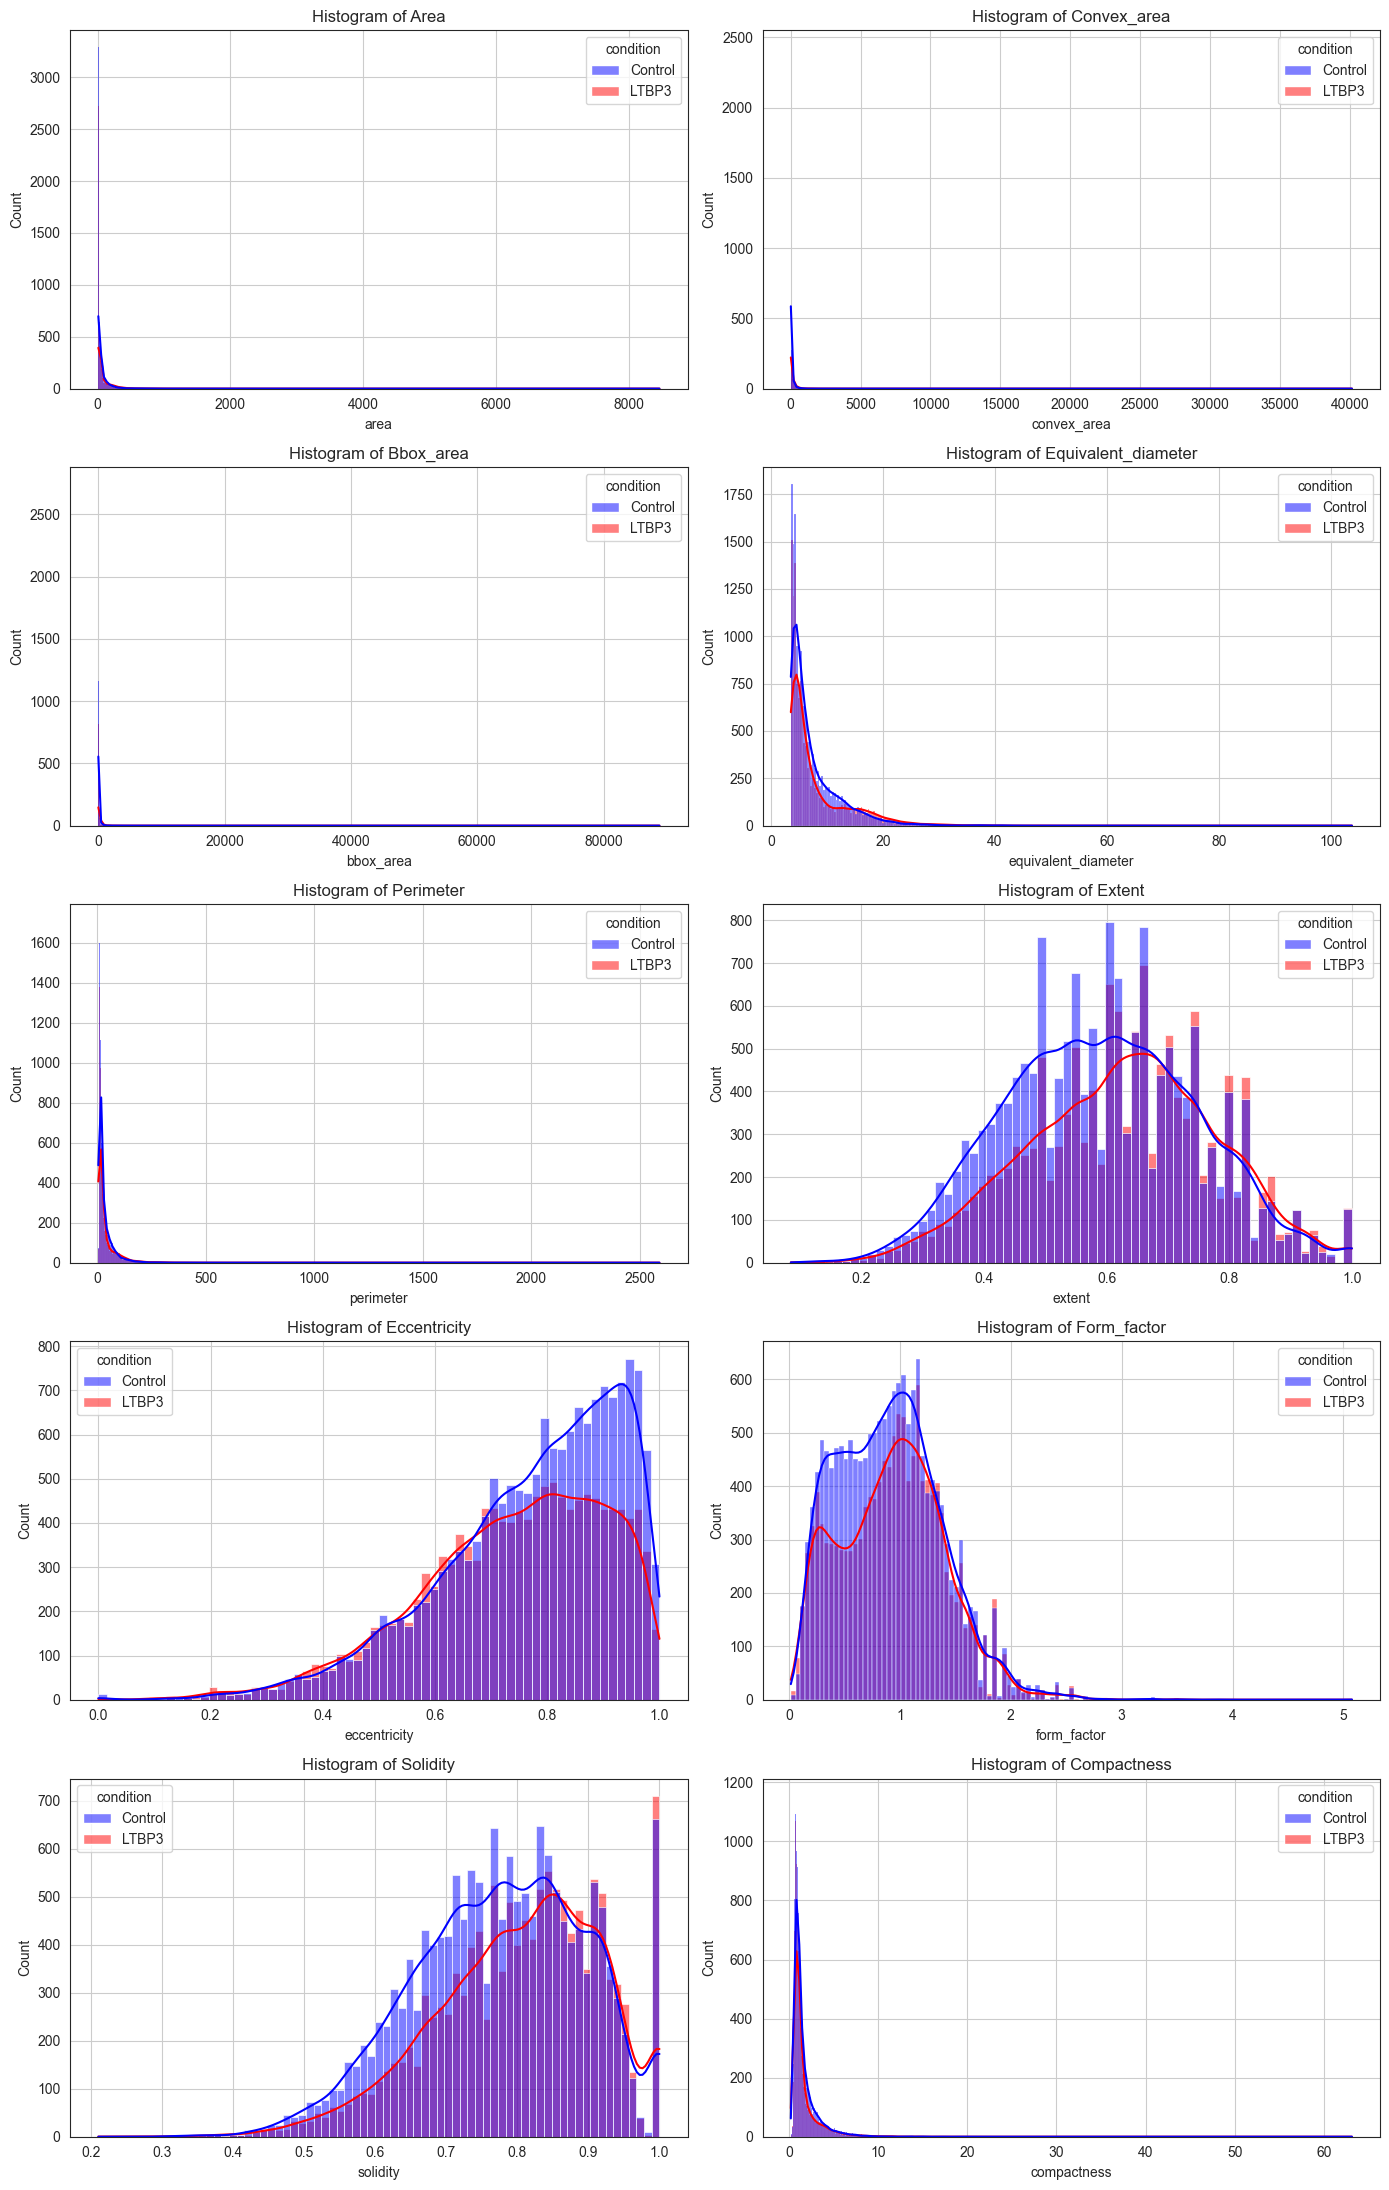

In [37]:
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(data=df_features, x=feature, hue='condition', kde=True, ax=axes[i], palette={'Control': 'blue', 'LTBP3': 'red'}, alpha=0.5)
    axes[i].set_title(f'Histogram of {feature.capitalize()}')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

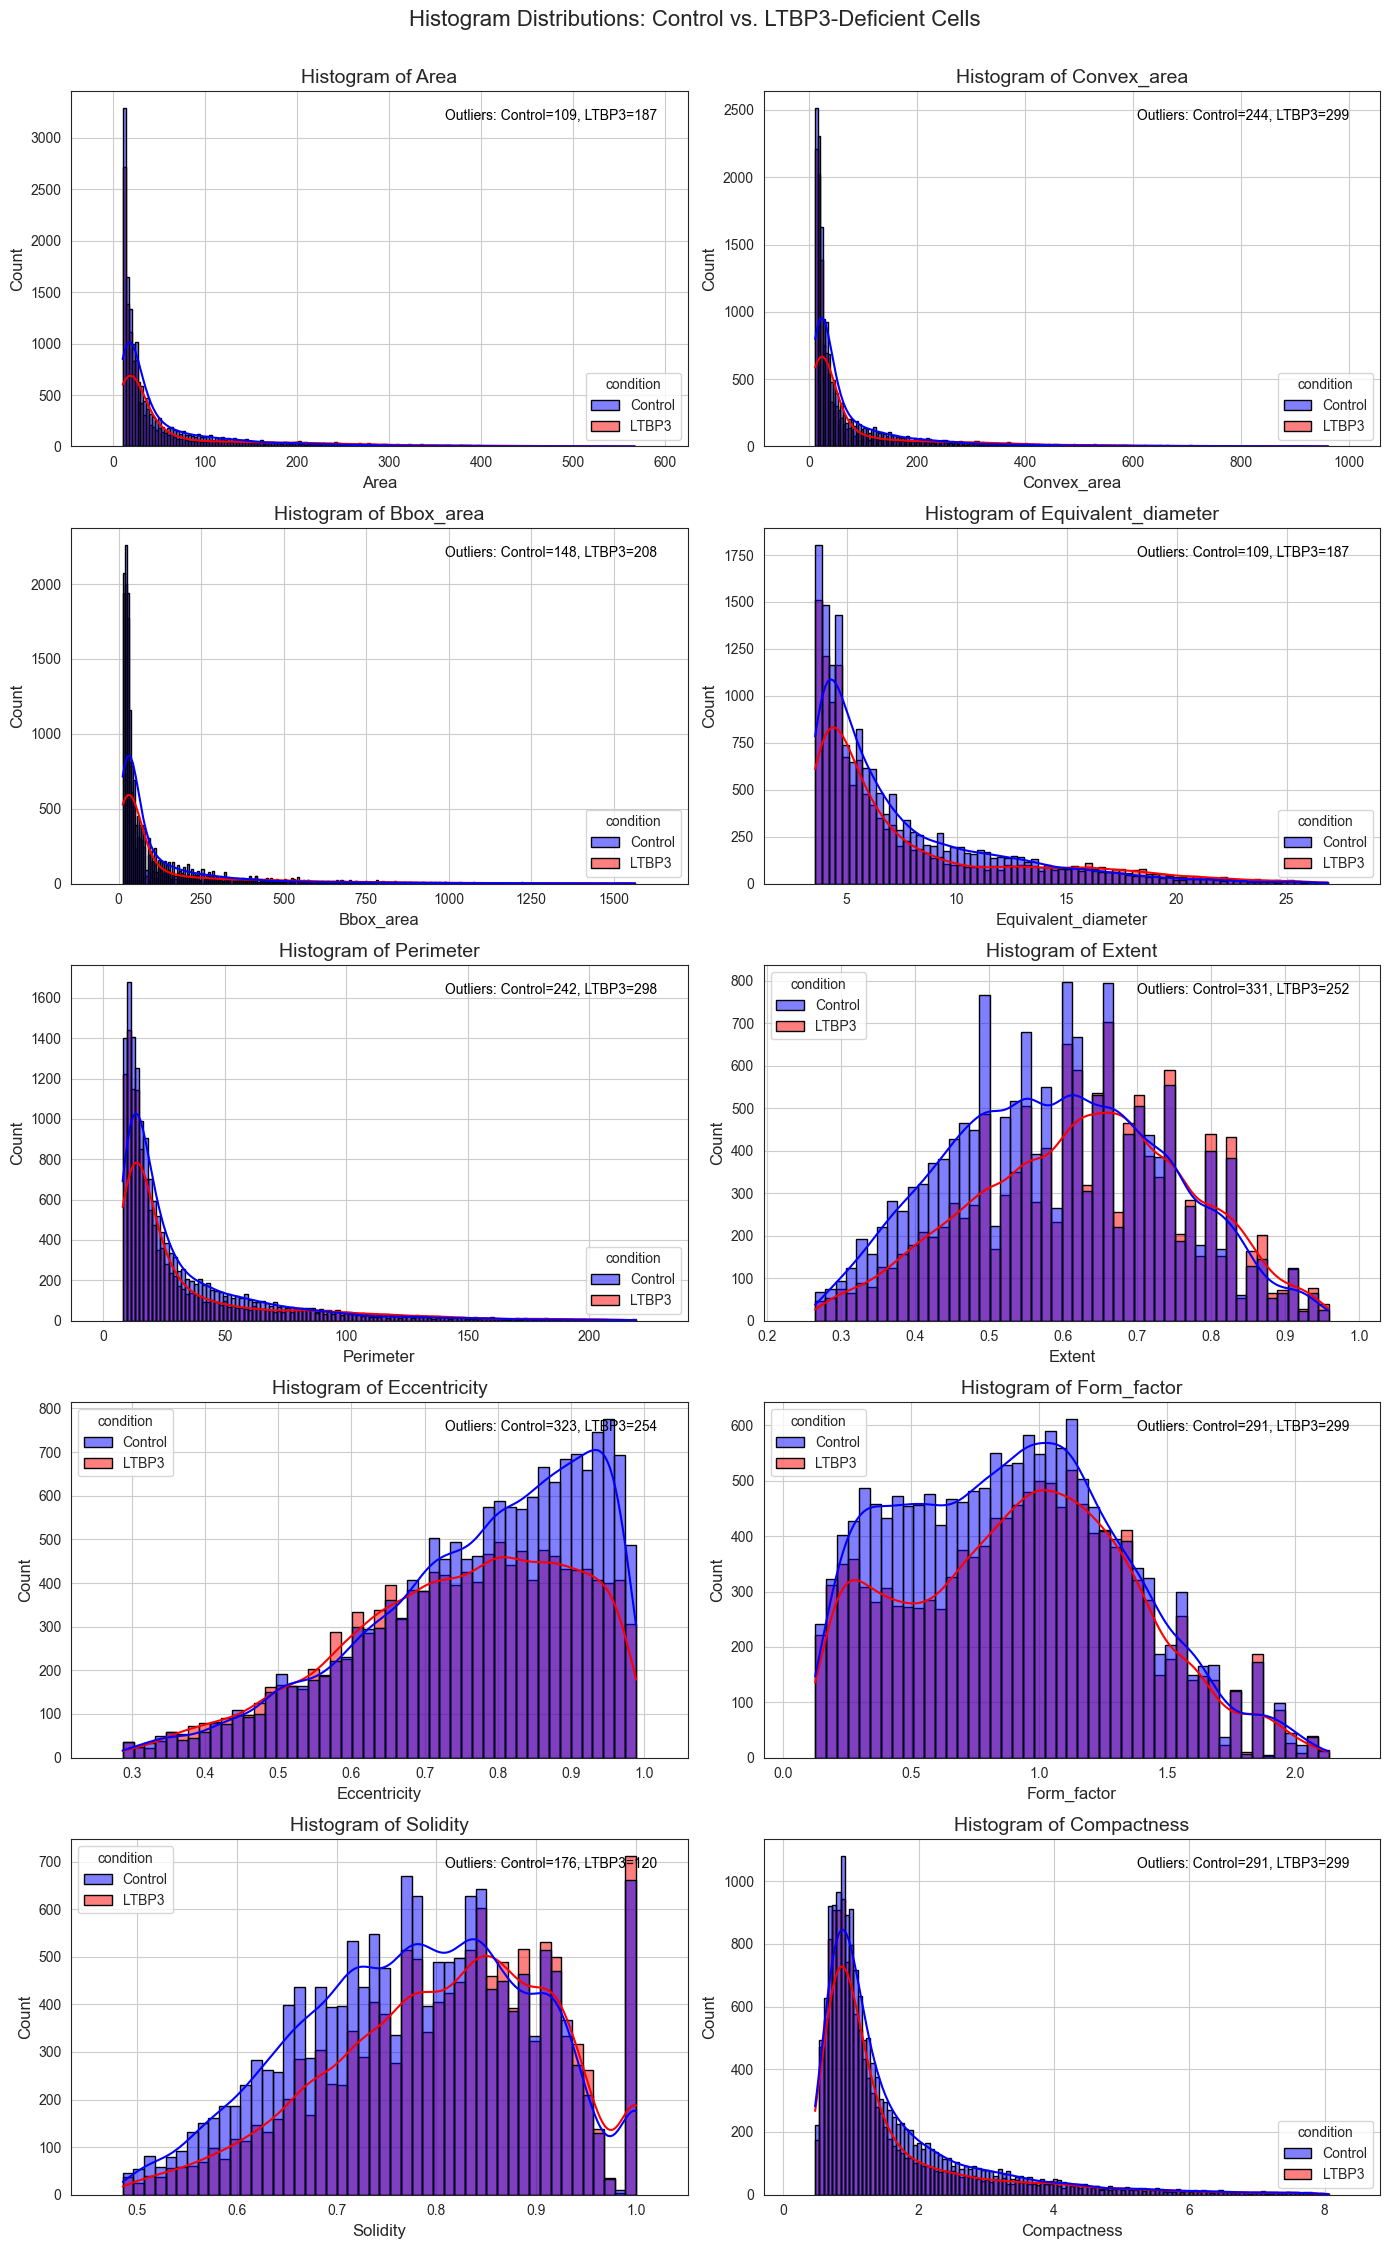

In [38]:
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = axes.flatten()

for i, feature in enumerate(features):
    # Filter data to remove extreme outliers (1st to 99th percentile)
    data = df_features[[feature, 'condition']].copy()
    q_low, q_high = data[feature].quantile([0.01, 0.99])
    data_filtered = data[(data[feature] >= q_low) & (data[feature] <= q_high)]
    # Plot histogram with KDE
    sns.histplot(data=data_filtered, x=feature, hue='condition', kde=True, ax=axes[i], 
                 palette={'Control': 'blue', 'LTBP3': 'red'}, alpha=0.5, edgecolor='black', linewidth=1)
    # Set x-axis limits to focus on main distribution
    axes[i].set_xlim(q_low - 0.1 * (q_high - q_low), q_high + 0.1 * (q_high - q_low))
    # Add annotations for outliers (count of points outside 1st-99th percentiles)
    n_outliers_control = len(data[(data['condition'] == 'Control') & ((data[feature] < q_low) | (data[feature] > q_high))])
    n_outliers_ltbp3 = len(data[(data['condition'] == 'LTBP3') & ((data[feature] < q_low) | (data[feature] > q_high))])
    axes[i].text(0.95, 0.95, f'Outliers: Control={n_outliers_control}, LTBP3={n_outliers_ltbp3}', 
                 transform=axes[i].transAxes, ha='right', va='top', fontsize=10, color='black')
    axes[i].set_title(f'Histogram of {feature.capitalize()}', fontsize=14)
    axes[i].set_xlabel(feature.capitalize(), fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].grid(True)

plt.tight_layout()
plt.suptitle('Histogram Distributions: Control vs. LTBP3-Deficient Cells', y=1.02, fontsize=16)
plt.show()

## Conclusions

LTBP3-deficient osteocytes show significant differences in morphology, such as larger area and altered compactness, consistent with hypertrophic phenotypes observed in knockout models with impaired TGF-β signaling. PCA and t-SNE reveal partial separation, suggesting heterogeneous responses. Clustering indicates overlap but distinct subgroups. Future work: integrate with gene expression data for mechanistic insights.